# Explanatory Notebook for Responsive Bayesian LSTM




## Table of Contents

### [1. Data Loading and Exploration](#1-data-loading-and-exploration)


###  [2. Feature Engineering](#2-feature-engineering)


### [3. Model Architecture](#3-model-architecture)


###  [4. Training Process](#4-training-process)


###  [5. Model Evaluation](#5-evaluation)


### [6. Results Visualization](#6-visualization)



This code was partially assisted by generative AI tools, including OpenAI's ChatGPT. The code has been reviewed and modified by a human to ensure correctness and clarity.


In [1]:
# Import all necessary libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
pyro.set_rng_seed(42)

# Device setup - prioritize MPS on macOS
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Configure matplotlib for better plots
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)

/Users/kristofferkjaer/miniconda3/envs/mbml/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: mps


## 1. Data Loading and Exploration

First, let's load our CS:GO match data and understand its structure. Our dataset contains frame-by-frame information about CS:GO rounds, including player counts, equipment values, and round outcomes.

Each row represents a single frame (timestep) in a round, and we have multiple frames per round showing how the game state evolves over time.

In [2]:
import json
import lzma
import os

import pandas as pd
from tqdm import tqdm

DATA_DIR = "data/lan"


def load_match(filepath):
    with lzma.open(filepath, "rt", encoding="utf-8") as f:
        return json.load(f)


def extract_frames_from_round(round_data, round_idx, match_id):
    frames_data = []
    winner = round_data["winningSide"]  # "CT" or "T"

    # Basic round-level info
    base_info = {
        "round_idx": round_idx,
        "ctTeam": round_data["ctSide"]["teamName"],
        "tTeam": round_data["tSide"]["teamName"],
        "ctBuyType": round_data["ctBuyType"],
        "tBuyType": round_data["tBuyType"],
        "ctEqVal": round_data["ctRoundStartEqVal"],
        "tEqVal": round_data["tRoundStartEqVal"],
        "ctSpend": round_data["ctRoundSpendMoney"],
        "tSpend": round_data["tRoundSpendMoney"],
        "rnd_winner": winner,
        "match_id": match_id,
        "team1_score": [round_data["ctScore"] if round_data["roundNum"] < 16 else round_data["tScore"]][0],
        "team2_score": [round_data["tScore"] if round_data["roundNum"] < 16 else round_data["ctScore"]][0],
    }

    for frame in round_data["frames"]:
        tick = frame.get("tick")
        seconds = frame.get("seconds")
        clock = frame.get("clockTime")

        # You can extract more state info here if needed
        frame_info = {
            "tick": tick,
            "seconds": seconds,
            "clock": clock,
            "bomb_planted": frame.get("bombPlanted", False),
            "num_util_ct": frame.get("ct", {}).get("totalUtility", 0),
            "num_util_t": frame.get("t", {}).get("totalUtility", 0),
            "num_ct_alive": frame.get("ct", {}).get("alivePlayers", []),
            "num_t_alive": frame.get("t", {}).get("alivePlayers", []),
        }

        # Merge frame + round info
        frames_data.append({**base_info, **frame_info})

    return frames_data


def extract_frames_from_match(match_data, match_id):
    all_frame_data = []

    for idx in range(len(match_data["gameRounds"])):
        rnd = match_data["gameRounds"][idx]
        round_frames = extract_frames_from_round(rnd, idx, match_id)
        all_frame_data.extend(round_frames)

    return all_frame_data


def load_all_matches_to_frames(data_dir):
    all_frames = []
    files = [f for f in os.listdir(data_dir) if f.endswith(".json.xz")][:10]

    for file in tqdm(files, desc="Loading matches"):
        path = os.path.join(data_dir, file)
        match_id = os.path.splitext(os.path.basename(file))[0]
        try:
            match = load_match(path)
            frames = extract_frames_from_match(match, match_id)
            all_frames.extend(frames)
        except Exception as e:
            print(f"Error processing {file}: {e}")

    return pd.DataFrame(all_frames)



df = load_all_matches_to_frames(DATA_DIR)
print(df.head())
df.to_csv("round_frame_data.csv", index=False)


Loading matches: 100%|██████████| 10/10 [00:08<00:00,  1.12it/s]



   round_idx ctTeam       tTeam ctBuyType  tBuyType  ctEqVal  tEqVal  ctSpend  \
0          0  FURIA  G2 Esports  Full Eco  Full Eco     1000    1000     2650   
1          0  FURIA  G2 Esports  Full Eco  Full Eco     1000    1000     2650   
2          0  FURIA  G2 Esports  Full Eco  Full Eco     1000    1000     2650   
3          0  FURIA  G2 Esports  Full Eco  Full Eco     1000    1000     2650   
4          0  FURIA  G2 Esports  Full Eco  Full Eco     1000    1000     2650   

   tSpend rnd_winner  ... team1_score  team2_score  tick   seconds  clock  \
0    3400          T  ...           0            0  3772  0.484375  01:55   
1    3400          T  ...           0            0  3836  0.984375  01:55   
2    3400          T  ...           0            0  3900  1.484375  01:54   
3    3400          T  ...           0            0  3964  1.984375  01:54   
4    3400          T  ...           0            0  4028  2.484375  01:53   

  bomb_planted  num_util_ct  num_util_t  num_ct_al

In [3]:
# Load the CS:GO match data
df = pd.read_csv('round_frame_data.csv')
print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")

# Display basic statistics
print(f"\nBasic Statistics:")
print(f"- Total frames: {len(df):,}")
print(f"- Unique matches: {df['match_id'].nunique()}")
print(f"- Unique rounds: {len(df.groupby(['match_id', 'round_idx']))}")
print(f"- Average frames per round: {len(df) / len(df.groupby(['match_id', 'round_idx'])):.1f}")

# Show sample data
print(f"\nSample data:")
df.head()

Dataset shape: (49700, 21)

Columns: ['round_idx', 'ctTeam', 'tTeam', 'ctBuyType', 'tBuyType', 'ctEqVal', 'tEqVal', 'ctSpend', 'tSpend', 'rnd_winner', 'match_id', 'team1_score', 'team2_score', 'tick', 'seconds', 'clock', 'bomb_planted', 'num_util_ct', 'num_util_t', 'num_ct_alive', 'num_t_alive']

Basic Statistics:
- Total frames: 49,700
- Unique matches: 10
- Unique rounds: 259
- Average frames per round: 191.9

Sample data:


,round_idx,ctTeam,tTeam,ctBuyType,tBuyType,ctEqVal,tEqVal,ctSpend,tSpend,rnd_winner,...,team1_score,team2_score,tick,seconds,clock,bomb_planted,num_util_ct,num_util_t,num_ct_alive,num_t_alive
0,0,FURIA,G2 Esports,Full Eco,Full Eco,1000,1000,2650,3400,T,...,0,0,3772,0.484375,01:55,False,1,2,5,5
1,0,FURIA,G2 Esports,Full Eco,Full Eco,1000,1000,2650,3400,T,...,0,0,3836,0.984375,01:55,False,1,2,5,5
2,0,FURIA,G2 Esports,Full Eco,Full Eco,1000,1000,2650,3400,T,...,0,0,3900,1.484375,01:54,False,1,2,5,5
3,0,FURIA,G2 Esports,Full Eco,Full Eco,1000,1000,2650,3400,T,...,0,0,3964,1.984375,01:54,False,1,2,5,5
4,0,FURIA,G2 Esports,Full Eco,Full Eco,1000,1000,2650,3400,T,...,0,0,4028,2.484375,01:53,False,1,2,5,5


## 2. Feature Engineering and Processing

Features are processed to create a suitable input for the model. This includes normalizing numerical features, encoding categorical variables, and creating sequences of frames for training.
This ensures that frames from the same round don't appear in both training and test sets, which would cause data leakage.

In [ ]:
def process_features(dataframe, feature_cols=None):
    """Extract features and identify special feature indices."""
    
    if feature_cols is None:
        # Use all numeric columns except specific metadata
        exclude_cols = ["match_id", "round_idx", "tick", "rnd_winner", "team1_score", "team2_score"]
        numeric_cols = dataframe.select_dtypes(include=["number"]).columns.tolist()
        feature_cols = [col for col in numeric_cols if col not in exclude_cols]

    # Identify player count features 
    player_count_cols = [col for col in feature_cols if "alive" in col.lower() or "players" in col.lower()]
    player_count_indices = [feature_cols.index(col) for col in player_count_cols]
    
    # Identify equipment value features
    equipment_cols = [col for col in feature_cols if "eqval" in col.lower() or "equipment" in col.lower()]
    equipment_indices = [feature_cols.index(col) for col in equipment_cols]
    

    return feature_cols, player_count_indices, equipment_indices

# Process features
feature_cols, player_count_indices, equipment_indices = process_features(df)
print(f"\nAll features: {feature_cols}")


All features: ['ctEqVal', 'tEqVal', 'ctSpend', 'tSpend', 'seconds', 'num_util_ct', 'num_util_t', 'num_ct_alive', 'num_t_alive']


## 3. Data Splitting Strategy

We split by **rounds**, not individual frames. This prevents data leakage where frames from the same round appear in both training and test sets.

Each round contains a sequence of frames showing how the game state evolves, and we want to predict the final outcome based on this sequence.

In [6]:
def prepare_data(dataframe, feature_cols, train_ratio=0.8):
    """Split data by rounds to prevent data leakage."""
    
    # Create labels (0 = CT win, 1 = T win)
    labels = []
    for _, row in dataframe.iterrows():
        winner = row["rnd_winner"]
        label = 0.0 if winner == "CT" else 1.0
        labels.append(label)
    
    # Get unique rounds
    unique_matches = dataframe["match_id"].unique()
    unique_rounds = []
    
    for match_id in unique_matches:
        match_rounds = dataframe[dataframe["match_id"] == match_id]["round_idx"].unique()
        for round_idx in match_rounds:
            unique_rounds.append((match_id, round_idx))
    
    print(f"Found {len(unique_rounds)} unique rounds")
    
    # Split into train and test sets
    np.random.shuffle(unique_rounds)
    train_size = int(len(unique_rounds) * train_ratio)
    train_rounds = unique_rounds[:train_size]
    test_rounds = unique_rounds[train_size:]
    
    print(f"Train set: {len(train_rounds)} rounds")
    print(f"Test set: {len(test_rounds)} rounds")
    
    # Create datasets
    train_features, train_labels = [], []
    test_features, test_labels = [], []
    
    for match_id, round_idx in train_rounds:
        round_df = dataframe[(dataframe["match_id"] == match_id) & (dataframe["round_idx"] == round_idx)]
        round_features = torch.tensor(round_df[feature_cols].values, dtype=torch.float32)
        
        winner = round_df.iloc[0]["rnd_winner"]
        round_label = 0.0 if winner == "CT" else 1.0
        round_labels = torch.tensor([round_label] * len(round_df), dtype=torch.float32)
        
        train_features.append(round_features)
        train_labels.append(round_labels)
    
    for match_id, round_idx in test_rounds:
        round_df = dataframe[(dataframe["match_id"] == match_id) & (dataframe["round_idx"] == round_idx)]
        round_features = torch.tensor(round_df[feature_cols].values, dtype=torch.float32)
        
        winner = round_df.iloc[0]["rnd_winner"]
        round_label = 0.0 if winner == "CT" else 1.0
        round_labels = torch.tensor([round_label] * len(round_df), dtype=torch.float32)
        
        test_features.append(round_features)
        test_labels.append(round_labels)
    
    return (train_features, train_labels), (test_features, test_labels)

# Prepare the data
(train_features, train_labels), (test_features, test_labels) = prepare_data(df, feature_cols)
print(f"\nPrepared {len(train_features)} training rounds and {len(test_features)} test rounds")

Found 259 unique rounds
Train set: 207 rounds
Test set: 52 rounds

Prepared 207 training rounds and 52 test rounds

Prepared 207 training rounds and 52 test rounds


## 4. Responsive Bayesian LSTM Architecture

We implement a Responsive Bayesian LSTM model that can adapt to the evolving game state.

In [12]:
import torch
import torch.nn as nn
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
from entmax import entmax15


class ResponsiveBayesianLSTM(PyroModule):
    """
    Bayesian LSTM with improved responsiveness to game events.
    
    This model combines:
    1. The event-sensitivity features from ResponsiveWinPredictor
    2. Uncertainty quantification through Bayesian treatment of parameters
    """
    
    def __init__(
        self,
        input_dim,
        hidden_dim=64,
        num_layers=2,
        dropout=0.2,
        player_count_indices=None,  # Indices of features related to player counts
        equipment_indices=None,     # Indices of features related to equipment
        use_entmax=True,            # Whether to use entmax activation (vs sigmoid)
    ):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.dropout = dropout
        self.player_count_indices = player_count_indices or []
        self.equipment_indices = equipment_indices or []
        self.use_entmax = use_entmax
        
        # Initial state projection (for equipment values)
        self.initial_state_projection = PyroModule[nn.Sequential](
            PyroModule[nn.Linear](input_dim, hidden_dim),
            PyroModule[nn.Tanh]()
        )
        
        # Main LSTM for sequence processing
        self.lstm = PyroModule[nn.LSTM](
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0,
        )
        
        # Event detection subnet - focused on player count changes
        if self.player_count_indices:
            player_count_dim = len(self.player_count_indices)
            self.event_detector = PyroModule[nn.Sequential](
                PyroModule[nn.Linear](player_count_dim * 2, hidden_dim // 2),  # Current + previous values
                PyroModule[nn.LeakyReLU](),
                PyroModule[nn.Linear](hidden_dim // 2, hidden_dim // 2),
                PyroModule[nn.LeakyReLU](),
            )
        
        # Output projection
        combined_dim = hidden_dim
        if self.player_count_indices:
            combined_dim += hidden_dim // 2
        
        self.output_projection = PyroModule[nn.Sequential](
            PyroModule[nn.Linear](combined_dim, hidden_dim),
            PyroModule[nn.LeakyReLU](),
            PyroModule[nn.Dropout](dropout),
            PyroModule[nn.Linear](hidden_dim, 2 if use_entmax else 1),  # 2 outputs for entmax, 1 for sigmoid
        )
    
    def extract_subfeatures(self, x, indices):
        """Extract specific feature dimensions from input tensor."""
        if not indices:
            return None
        return x[:, :, indices]
    
    def forward(self, x):
        """
        Forward pass with Bayesian uncertainty and enhanced sensitivity to game events.
        
        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, seq_len, input_dim)
            
        Returns:
            torch.Tensor: Output probability vector of shape (batch_size, seq_len)
        """
        batch_size, seq_len, _ = x.shape
        
        # Create initial state based on first frame equipment values
        if self.equipment_indices:
            equipment_values = self.extract_subfeatures(x, self.equipment_indices)
            initial_state = self.initial_state_projection(x[:, 0])
            h0 = initial_state.unsqueeze(0).repeat(self.lstm.num_layers, 1, 1)
            c0 = torch.zeros_like(h0)
            initial_states = (h0, c0)
        else:
            initial_states = None
        
        # Main LSTM processing
        lstm_out, _ = self.lstm(x, initial_states)
        
        # Event detection for player counts
        event_features = None
        if self.player_count_indices:
            player_counts = self.extract_subfeatures(x, self.player_count_indices)
            
            # Get current and previous player counts
            current_counts = player_counts
            prev_counts = torch.cat([player_counts[:, :1], player_counts[:, :-1]], dim=1)
            
            # Concatenate for delta detection
            player_deltas = torch.cat([current_counts, prev_counts], dim=2)
            
            # Process through event detector
            event_features = self.event_detector(player_deltas)
        
        # Combine features
        if event_features is not None:
            combined_features = torch.cat([lstm_out, event_features], dim=2)
        else:
            combined_features = lstm_out
        
        # Output projection
        logits = self.output_projection(combined_features)
        
        # Apply activation
        if self.use_entmax:
            # Reshape for entmax
            batch_size, seq_len, output_dim = logits.shape
            logits_reshaped = logits.reshape(-1, output_dim)
            probs_reshaped = entmax15(logits_reshaped, dim=-1)
            probs = probs_reshaped.reshape(batch_size, seq_len, output_dim)
            return probs[:, :, 1]  # Return probability of positive class
        else:
            # Apply sigmoid for binary output
            return torch.sigmoid(logits.squeeze(-1))
    
    def model(self, x, y=None):
        """
        Pyro model - defines the probabilistic generative process.
        """
        # Register modules with Pyro
        pyro.module("initial_state_projection", self.initial_state_projection)
        pyro.module("lstm", self.lstm)
        
        if hasattr(self, "event_detector"):
            pyro.module("event_detector", self.event_detector)
            
        pyro.module("output_projection", self.output_projection)
        
        # Get predictions from forward pass
        predictions = self.forward(x)
        
        # Simple likelihood - sample observations where we have valid data
        if y is not None:
            batch_size, seq_len = predictions.shape
            for i in range(batch_size):
                for j in range(seq_len):
                    # Skip positions with NaN labels
                    if torch.isnan(y[i, j]):
                        continue
                        
                    pyro.sample(
                        f"obs_{i}_{j}", 
                        dist.Bernoulli(predictions[i, j]), 
                        obs=y[i, j]
                    )
        
        return predictions
    
    def guide(self, x, y=None):
        """
        Pyro guide - defines the variational approximation.
        For simplicity, just register the model parameters.
        """
        pyro.module("initial_state_projection", self.initial_state_projection)
        pyro.module("lstm", self.lstm)
        
        if hasattr(self, "event_detector"):
            pyro.module("event_detector", self.event_detector)
            
        pyro.module("output_projection", self.output_projection)


## 5. Training with Stochastic Variational Inference (SVI)

Instead of traditional backpropagation, we use **Stochastic Variational Inference** with ELBO (Evidence Lower Bound) to train our model. This allows us to learn a distribution over the model parameters.

Input dimension: 9
Player count indices: [7, 8]
Equipment indices: [0, 1]
Starting training with exact same method as train_responsive_bayesian.py...


Epoch 1/5: 0it [00:00, ?it/s]

Epoch 1/5: 207it [00:13, 15.58it/s]
Epoch 1/5: 207it [00:13, 15.58it/s]
Testing: 52it [00:01, 48.42it/s]
Testing: 52it [00:01, 48.42it/s]


Epoch 1/5, Train Loss: 222.7523, Test Loss: 117.6117
Saved best model (test loss: 117.6117)


Epoch 2/5: 207it [00:13, 15.83it/s]
Epoch 2/5: 207it [00:13, 15.83it/s]
Testing: 52it [00:01, 34.24it/s]
Testing: 52it [00:01, 34.24it/s]


Epoch 2/5, Train Loss: 153.5024, Test Loss: 128.4032


Epoch 3/5: 207it [00:12, 16.38it/s]
Epoch 3/5: 207it [00:12, 16.38it/s]
Testing: 52it [00:00, 54.45it/s]
Testing: 52it [00:00, 54.45it/s]


Epoch 3/5, Train Loss: 129.9038, Test Loss: 112.7517
Saved best model (test loss: 112.7517)


Epoch 4/5: 207it [00:12, 16.79it/s]
Epoch 4/5: 207it [00:12, 16.79it/s]
Testing: 52it [00:00, 54.94it/s]
Testing: 52it [00:00, 54.94it/s]


Epoch 4/5, Train Loss: 154.4905, Test Loss: 219.6820


Epoch 5/5: 207it [00:12, 16.27it/s]
Epoch 5/5: 207it [00:12, 16.27it/s]
Testing: 52it [00:01, 36.19it/s]



Epoch 5/5, Train Loss: 467.4907, Test Loss: 1547.9152


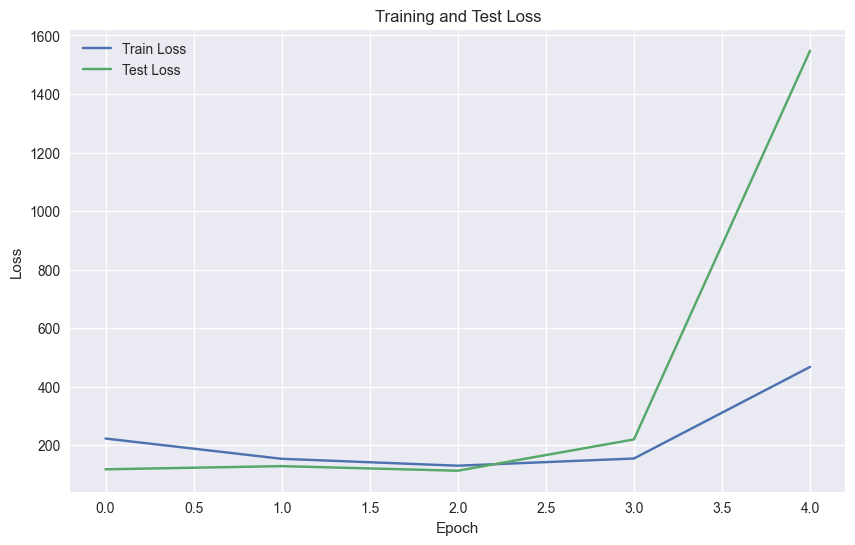

Saved final model
Training completed successfully!


In [ ]:
# Training parameters - matching train_responsive_bayesian.py exactly
args_dict = {
    'hidden_dim': 64,
    'num_layers': 2,
    'dropout': 0.2,
    'learning_rate': 0.01,
    'num_epochs': 3,
    'use_entmax': True,
    'output_dir': './saved_models/responsive_bayesian_notebook',
}

# Convert dict to object for compatibility
class Args:
    def __init__(self, **kwargs):
        for key, value in kwargs.items():
            setattr(self, key, value)

args = Args(**args_dict)

# Extract input dimension from the first feature set
input_dim = train_features[0].shape[1] if train_features else 0

# Create the model
model = ResponsiveBayesianLSTM(
    input_dim=input_dim,
    hidden_dim=args.hidden_dim,
    num_layers=args.num_layers,
    dropout=args.dropout,
    player_count_indices=player_count_indices,
    equipment_indices=equipment_indices,
    use_entmax=args.use_entmax
)

# Set up Pyro optimizer and SVI - EXACT SAME AS TRAINING SCRIPT
pyro.clear_param_store()
adam = Adam({"lr": args.learning_rate})
elbo = Trace_ELBO()
svi = SVI(model.model, model.guide, adam, loss=elbo)

# Create directory for saving model
output_dir = Path(args.output_dir)
output_dir.mkdir(parents=True, exist_ok=True)

# Training loop - EXACT COPY FROM train_responsive_bayesian.py
train_losses = []
test_losses = []
best_test_loss = float('inf')

print("Starting training with exact same method as train_responsive_bayesian.py...")

for epoch in range(args.num_epochs):
    # Train
    epoch_train_loss = 0.0
    num_train_batches = 0
    
    for features, labels in tqdm(zip(train_features, train_labels), desc=f"Epoch {epoch+1}/{args.num_epochs}"):
        # Add batch dimension
        features = features.unsqueeze(0)
        labels = labels.unsqueeze(0)
        
        # Compute loss
        loss = svi.step(features, labels)
        epoch_train_loss += loss
        num_train_batches += 1
    
    avg_train_loss = epoch_train_loss / num_train_batches if num_train_batches > 0 else float('inf')
    train_losses.append(avg_train_loss)
    
    # Test
    epoch_test_loss = 0.0
    num_test_batches = 0
    
    for features, labels in tqdm(zip(test_features, test_labels), desc="Testing"):
        # Add batch dimension
        features = features.unsqueeze(0)
        labels = labels.unsqueeze(0)
        
        # Compute loss
        loss = svi.evaluate_loss(features, labels)
        epoch_test_loss += loss
        num_test_batches += 1
    
    avg_test_loss = epoch_test_loss / num_test_batches if num_test_batches > 0 else float('inf')
    test_losses.append(avg_test_loss)
    
    print(f"Epoch {epoch+1}/{args.num_epochs}, Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")
    
    # Save the best model
    if avg_test_loss < best_test_loss:
        best_test_loss = avg_test_loss
        
        # Save model checkpoint
        checkpoint = {
            'model_state_dict': model.state_dict(),
            'epoch': epoch,
            'train_loss': avg_train_loss,
            'test_loss': avg_test_loss,
            'input_dim': input_dim,
            'hidden_dim': args.hidden_dim,
            'num_layers': args.num_layers,
            'dropout': args.dropout,
            'player_count_indices': player_count_indices,
            'equipment_indices': equipment_indices,
            'use_entmax': args.use_entmax
        }
        
        torch.save(checkpoint, output_dir / "best_model.pt")
        print(f"Saved best model (test loss: {avg_test_loss:.4f})")

# Plot training and test loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Test Loss")
plt.legend()
plt.grid(True)
plt.savefig(output_dir / "training_loss.png")
plt.show()

# Save final model
checkpoint = {
    'model_state_dict': model.state_dict(),
    'epoch': args.num_epochs,
    'train_loss': train_losses[-1],
    'test_loss': test_losses[-1],
    'input_dim': input_dim,
    'hidden_dim': args.hidden_dim,
    'num_layers': args.num_layers,
    'dropout': args.dropout,
    'player_count_indices': player_count_indices,
    'equipment_indices': equipment_indices,
    'use_entmax': args.use_entmax
}

torch.save(checkpoint, output_dir / "final_model.pt")
print(f"Saved final model")

print("Training completed successfully!")

## 6. Model Evaluation with Uncertainty Quantification

Now we'll evaluate our model using **Monte Carlo sampling** to get both an accuracy metric for the model: 

In [16]:
def predict_with_uncertainty(model, features, num_samples=30):
    """Get predictions with uncertainty estimates using Monte Carlo sampling."""
    model.train()  # Enable dropout for sampling
    predictions = []
    
    with torch.no_grad():
        for _ in range(num_samples):
            pred = model(features.unsqueeze(0))
            predictions.append(pred.squeeze(0).cpu().numpy())
    
    predictions = np.array(predictions)
    
    mean_pred = np.mean(predictions, axis=0)
    std_pred = np.std(predictions, axis=0)
    lower_95 = np.percentile(predictions, 2.5, axis=0)
    upper_95 = np.percentile(predictions, 97.5, axis=0)
    
    return mean_pred, std_pred, lower_95, upper_95

# Evaluate on test set
correct_predictions = 0
total_predictions = 0
detailed_results = []

print("Evaluating model accuracy...")
for i, (features, labels) in enumerate(tqdm(zip(test_features[:100], test_labels[:100]), desc="Evaluating")):
    # Get predictions with uncertainty
    mean_pred, std_pred, lower_95, upper_95 = predict_with_uncertainty(model, features)
    
    # Use final prediction to determine winner
    final_prediction = mean_pred[-1]
    final_uncertainty = std_pred[-1]
    
    # Convert to binary decision (T win probability > 0.5 means T wins)
    predicted_winner = "T" if final_prediction > 0.5 else "CT"
    predicted_label = 1.0 if final_prediction > 0.5 else 0.0
    
    # Get true label
    true_label = labels[0].item()  # All frames in a round have same label
    true_winner = "T" if true_label > 0.5 else "CT"
    
    # Check if correct
    is_correct = predicted_label == true_label
    if is_correct:
        correct_predictions += 1
    total_predictions += 1
    
    # Store results
    detailed_results.append({
        'round_idx': i,
        'true_winner': true_winner,
        'predicted_winner': predicted_winner,
        'final_prediction': final_prediction,
        'final_uncertainty': final_uncertainty,
        'is_correct': is_correct,
        'confidence': abs(final_prediction - 0.5) * 2
    })

accuracy = correct_predictions / total_predictions
print(f"\nAccuracy on {total_predictions} test rounds: {accuracy:.4f} ({accuracy*100:.2f}%)")

# Show some examples
print("\nExample predictions:")
for i, result in enumerate(detailed_results[:10]):
    status = "✓" if result['is_correct'] else "✗"
    print(f"Round {i+1}: True={result['true_winner']}, Pred={result['predicted_winner']} "
          f"(prob={result['final_prediction']:.3f}±{result['final_uncertainty']:.3f}) {status}")

Evaluating model accuracy...


Evaluating: 52it [00:07,  6.54it/s]


Accuracy on 52 test rounds: 0.3462 (34.62%)

Example predictions:
Round 1: True=CT, Pred=T (prob=0.804±0.278) ✗
Round 2: True=T, Pred=T (prob=0.893±0.243) ✓
Round 3: True=CT, Pred=T (prob=0.942±0.174) ✗
Round 4: True=CT, Pred=T (prob=0.819±0.277) ✗
Round 5: True=T, Pred=T (prob=0.977±0.123) ✓
Round 6: True=CT, Pred=T (prob=0.903±0.217) ✗
Round 7: True=CT, Pred=T (prob=0.868±0.241) ✗
Round 8: True=CT, Pred=T (prob=0.901±0.222) ✗
Round 9: True=CT, Pred=T (prob=0.965±0.133) ✗
Round 10: True=CT, Pred=T (prob=0.905±0.213) ✗


## 7. Prediction Visualization

Let's visualize how our model makes predictions over time for a specific round.
The visualization will show the model's predicted probabilities for each team winning as the round progresses, along with the actual outcome. The number of players and equipment values will also be displayed to provide context.


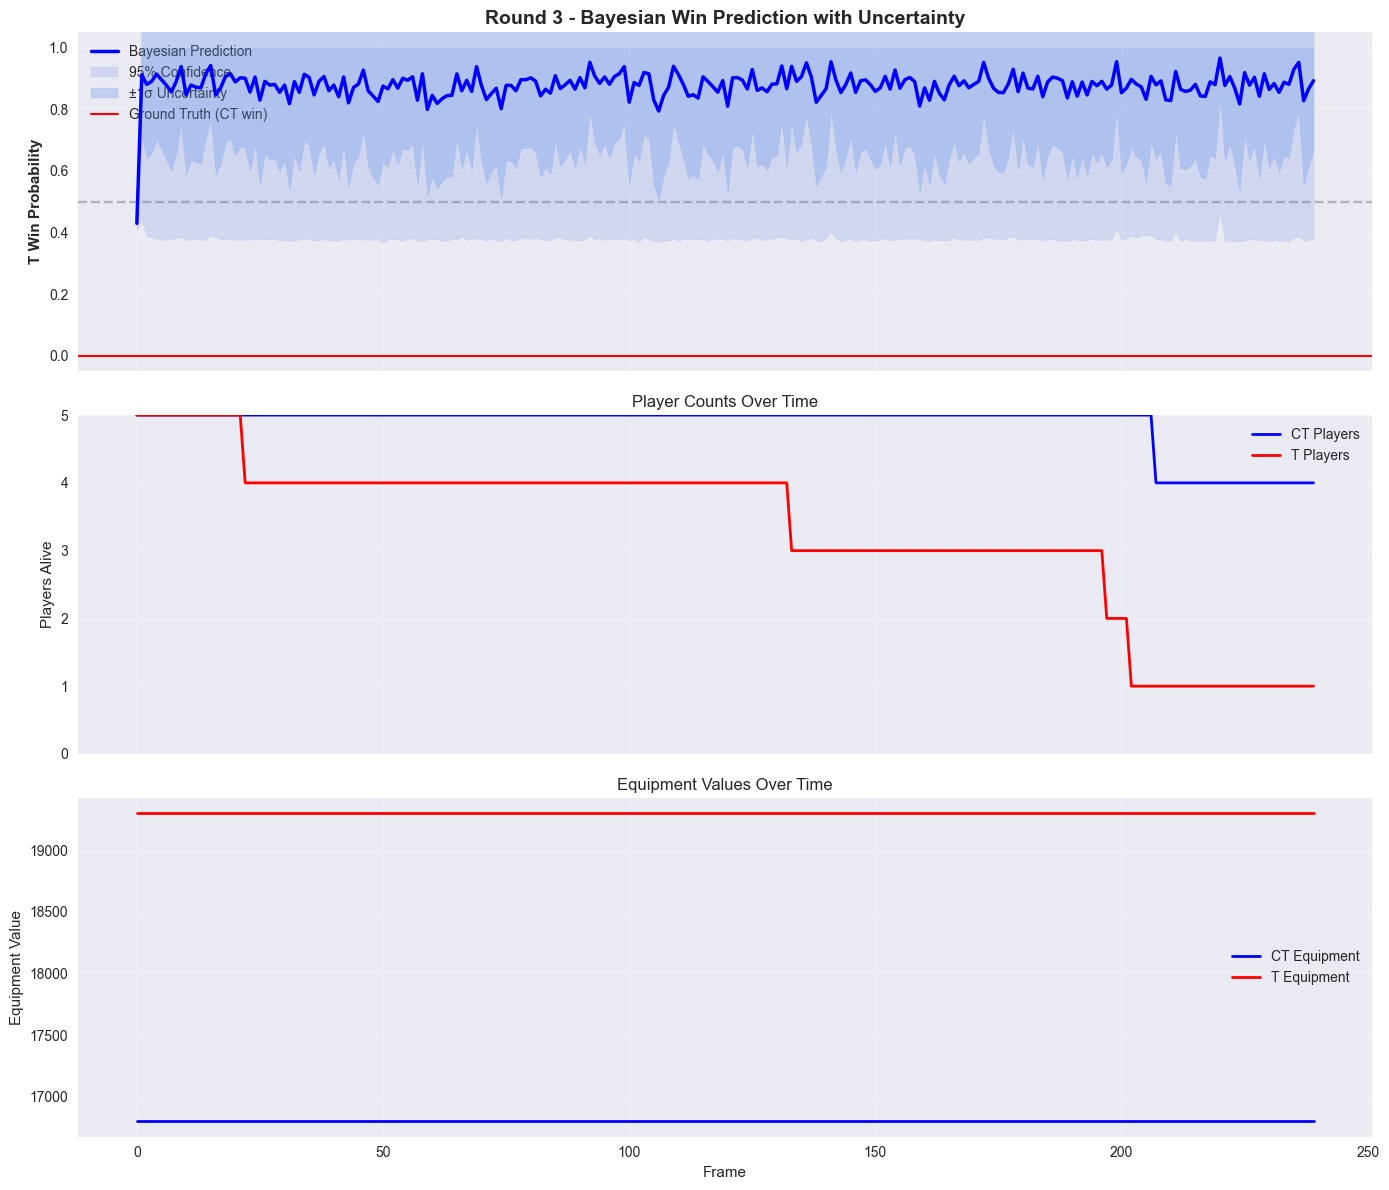


Prediction Summary for Round 3:
Ground Truth: CT wins
Prediction: T wins (probability: 0.893 ± 0.229)
Correct: No
Average uncertainty: 0.236


In [19]:
# Select an interesting test round for visualization
round_idx = 2  # You can change this to visualize different rounds
features = test_features[round_idx]
labels = test_labels[round_idx]

# Get predictions with uncertainty
mean_pred, std_pred, lower_95, upper_95 = predict_with_uncertainty(model, features, num_samples=50)

# Get ground truth
true_label = labels[0].item()
true_winner = "T" if true_label > 0.5 else "CT"

# Create visualization
fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)
frames = np.arange(len(mean_pred))

# Plot 1: Predictions with uncertainty
axes[0].plot(frames, mean_pred, "b-", label="Bayesian Prediction", linewidth=2.5, zorder=10)
axes[0].fill_between(frames, lower_95, upper_95, 
                    alpha=0.15, color="royalblue", label="95% Confidence", zorder=5)
axes[0].fill_between(frames, mean_pred - std_pred, mean_pred + std_pred, 
                    alpha=0.3, color="cornflowerblue", label="±1σ Uncertainty", zorder=7)

# Add ground truth
axes[0].axhline(y=true_label, color="r", linestyle="-", 
               label=f"Ground Truth ({true_winner} win)", linewidth=1.5, zorder=8)
axes[0].axhline(y=0.5, color="gray", linestyle="--", alpha=0.5, zorder=2)

axes[0].set_title(f"Round {round_idx+1} - Bayesian Win Prediction with Uncertainty", fontsize=14, fontweight='bold')
axes[0].set_ylabel("T Win Probability", fontweight='bold')
axes[0].legend(loc='upper left', framealpha=0.9)
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim(-0.05, 1.05)

# Plot 2: Player counts
ct_alive_idx = None
t_alive_idx = None

for i, col in enumerate(feature_cols):
    if "num_ct_alive" in col.lower():
        ct_alive_idx = i
    elif "num_t_alive" in col.lower():
        t_alive_idx = i

if ct_alive_idx is not None:
    axes[1].plot(features[:, ct_alive_idx].numpy(), "b-", label="CT Players", linewidth=2.0)
if t_alive_idx is not None:
    axes[1].plot(features[:, t_alive_idx].numpy(), "r-", label="T Players", linewidth=2.0)

axes[1].set_ylabel("Players Alive")
axes[1].set_ylim(0, 5)
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_title("Player Counts Over Time")

# Plot 3: Equipment values
ct_eq_idx = None
t_eq_idx = None

for i, col in enumerate(feature_cols):
    if "cteqval" in col.lower() or "ctequipvalue" in col.lower():
        ct_eq_idx = i
    elif "teqval" in col.lower() or "tequipvalue" in col.lower():
        t_eq_idx = i

if ct_eq_idx is not None:
    axes[2].plot(features[:, ct_eq_idx].numpy(), "b-", label="CT Equipment", linewidth=2.0)
if t_eq_idx is not None:
    axes[2].plot(features[:, t_eq_idx].numpy(), "r-", label="T Equipment", linewidth=2.0)

axes[2].set_ylabel("Equipment Value")
axes[2].set_xlabel("Frame")
axes[2].legend()
axes[2].grid(True, alpha=0.3)
axes[2].set_title("Equipment Values Over Time")

plt.tight_layout()
plt.show()

# Print prediction summary
final_pred = mean_pred[-1]
final_uncertainty = std_pred[-1]
predicted_winner = "T" if final_pred > 0.5 else "CT"
is_correct = (predicted_winner == true_winner)

print(f"\nPrediction Summary for Round {round_idx+1}:")
print(f"Ground Truth: {true_winner} wins")
print(f"Prediction: {predicted_winner} wins (probability: {final_pred:.3f} ± {final_uncertainty:.3f})")
print(f"Correct: {'Yes' if is_correct else 'No'}")
print(f"Average uncertainty: {np.mean(std_pred):.3f}")